#### TYK2 Library Diversity QC

We have two chunks (15 and 16), each with two types of samples (plasmid and gDNA) and two replicates of each group (A and  B) for 2\*2\*2 = 8 samples total. We demultiplexed, counted reads per unique barcode sequence, and mapped those barcode counts back to their parent oligos. Considering the set of barcodes succesfully associated to an oligo, we have the following counts of unique barcodes per sample:

In [51]:
library(vroom)
library(knitr)
library(ggpubr)
library(patchwork)
library(tidyverse)

In [22]:
mapped_counts <- vroom("../pipeline/tyk2-div-qc-form.mapped-counts.tsv",
                      col_names = c("sample", "barcode", "count", "lib", "chunk", "wt_aa", "pos",
                                    "mut_aa", "wt_codon", "mut_codon", "chunkID",
                                    "dox", "condition", "condition_conc","clone")) %>%
    group_by(sample) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           stop_counts = sum(count[which(mut_aa == "*")]),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) 

Rows: 3943453 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition...
dbl (6): count, chunk, pos, chunkID, dox, condition_conc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

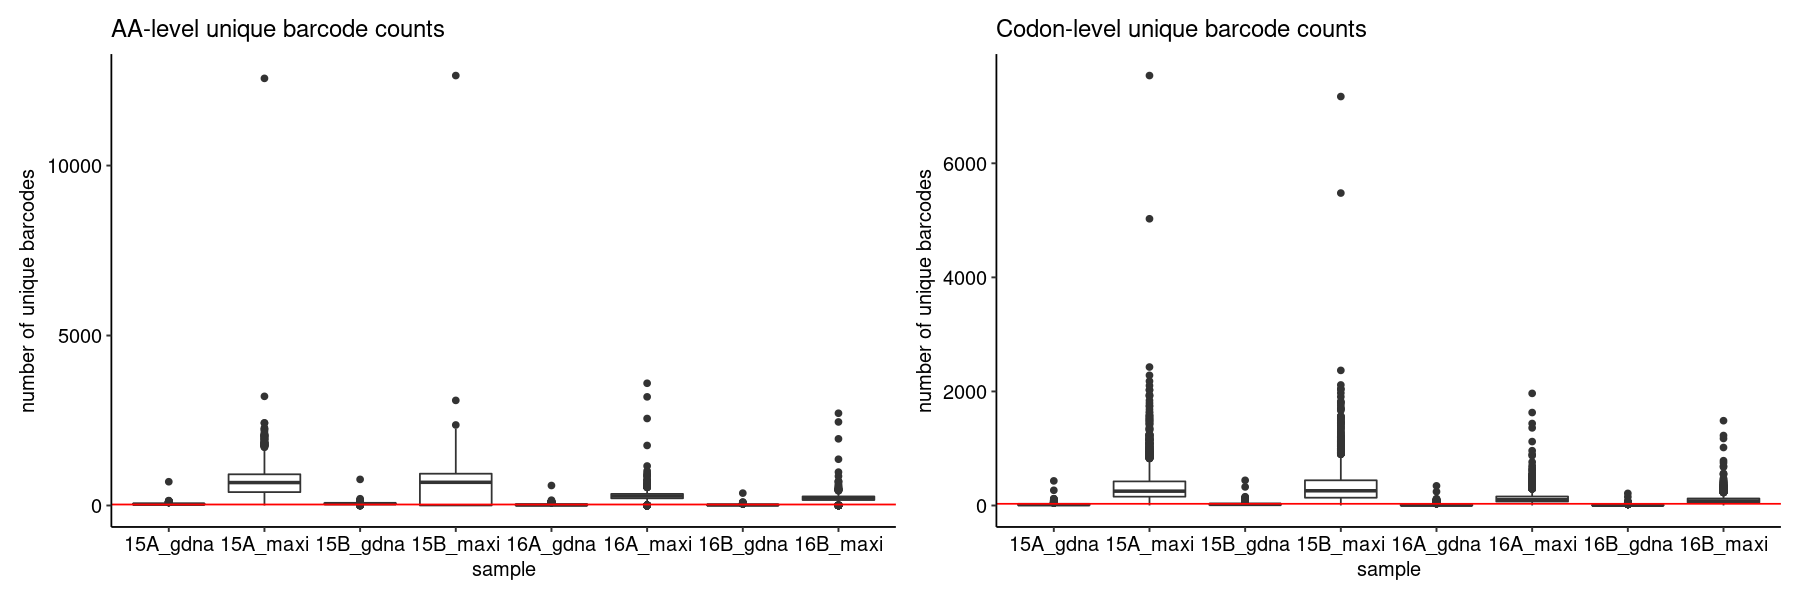

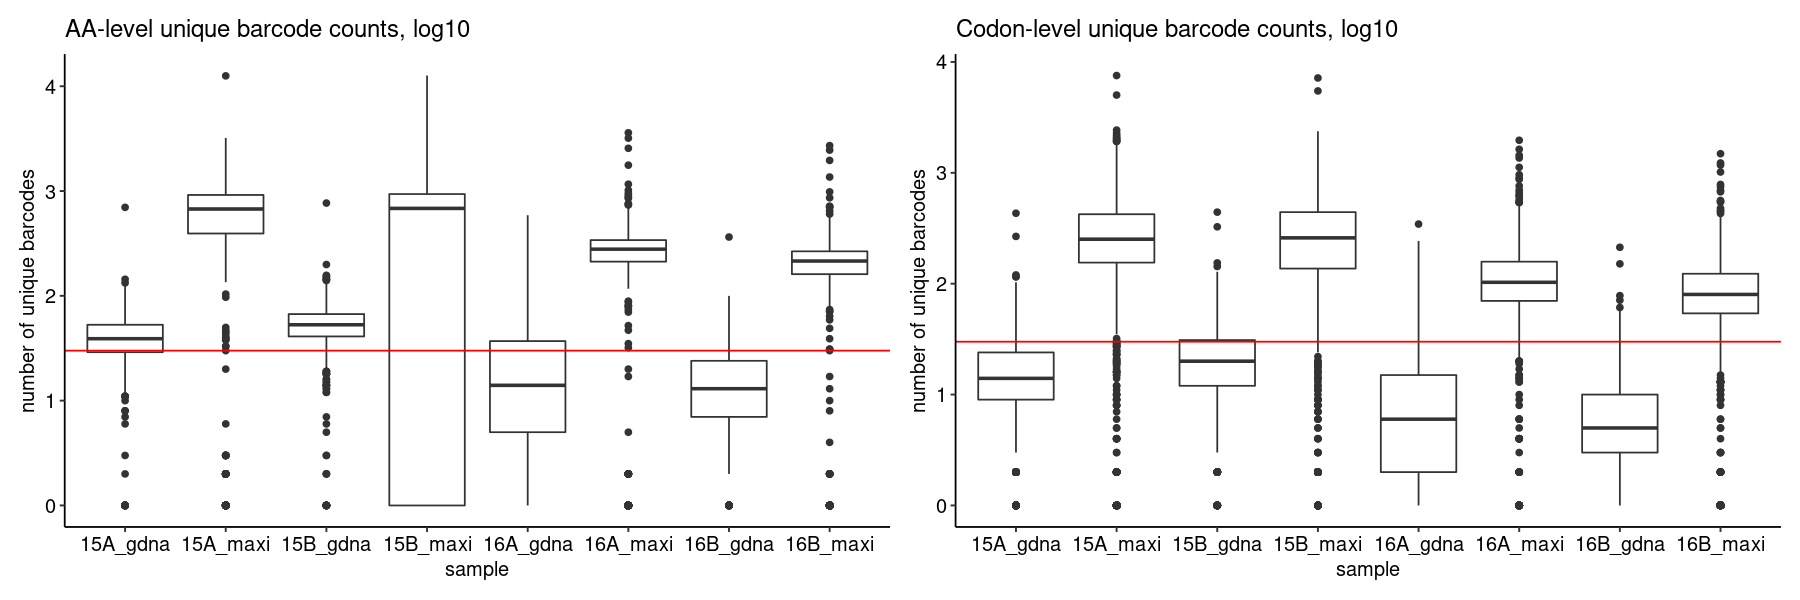

In [30]:
options(repr.plot.width = 15, repr.plot.height = 5)
res_count + codon_count
res_count_log + codon_count_log 

Next, we can plot the number of reads for each "unique barcode" detected. We see that in addition to there being fewer mapped barcodes per variant in chunk 16, there are also far more barcodes with very low counts in chunk 16 in gDNA (but not in plasmid):

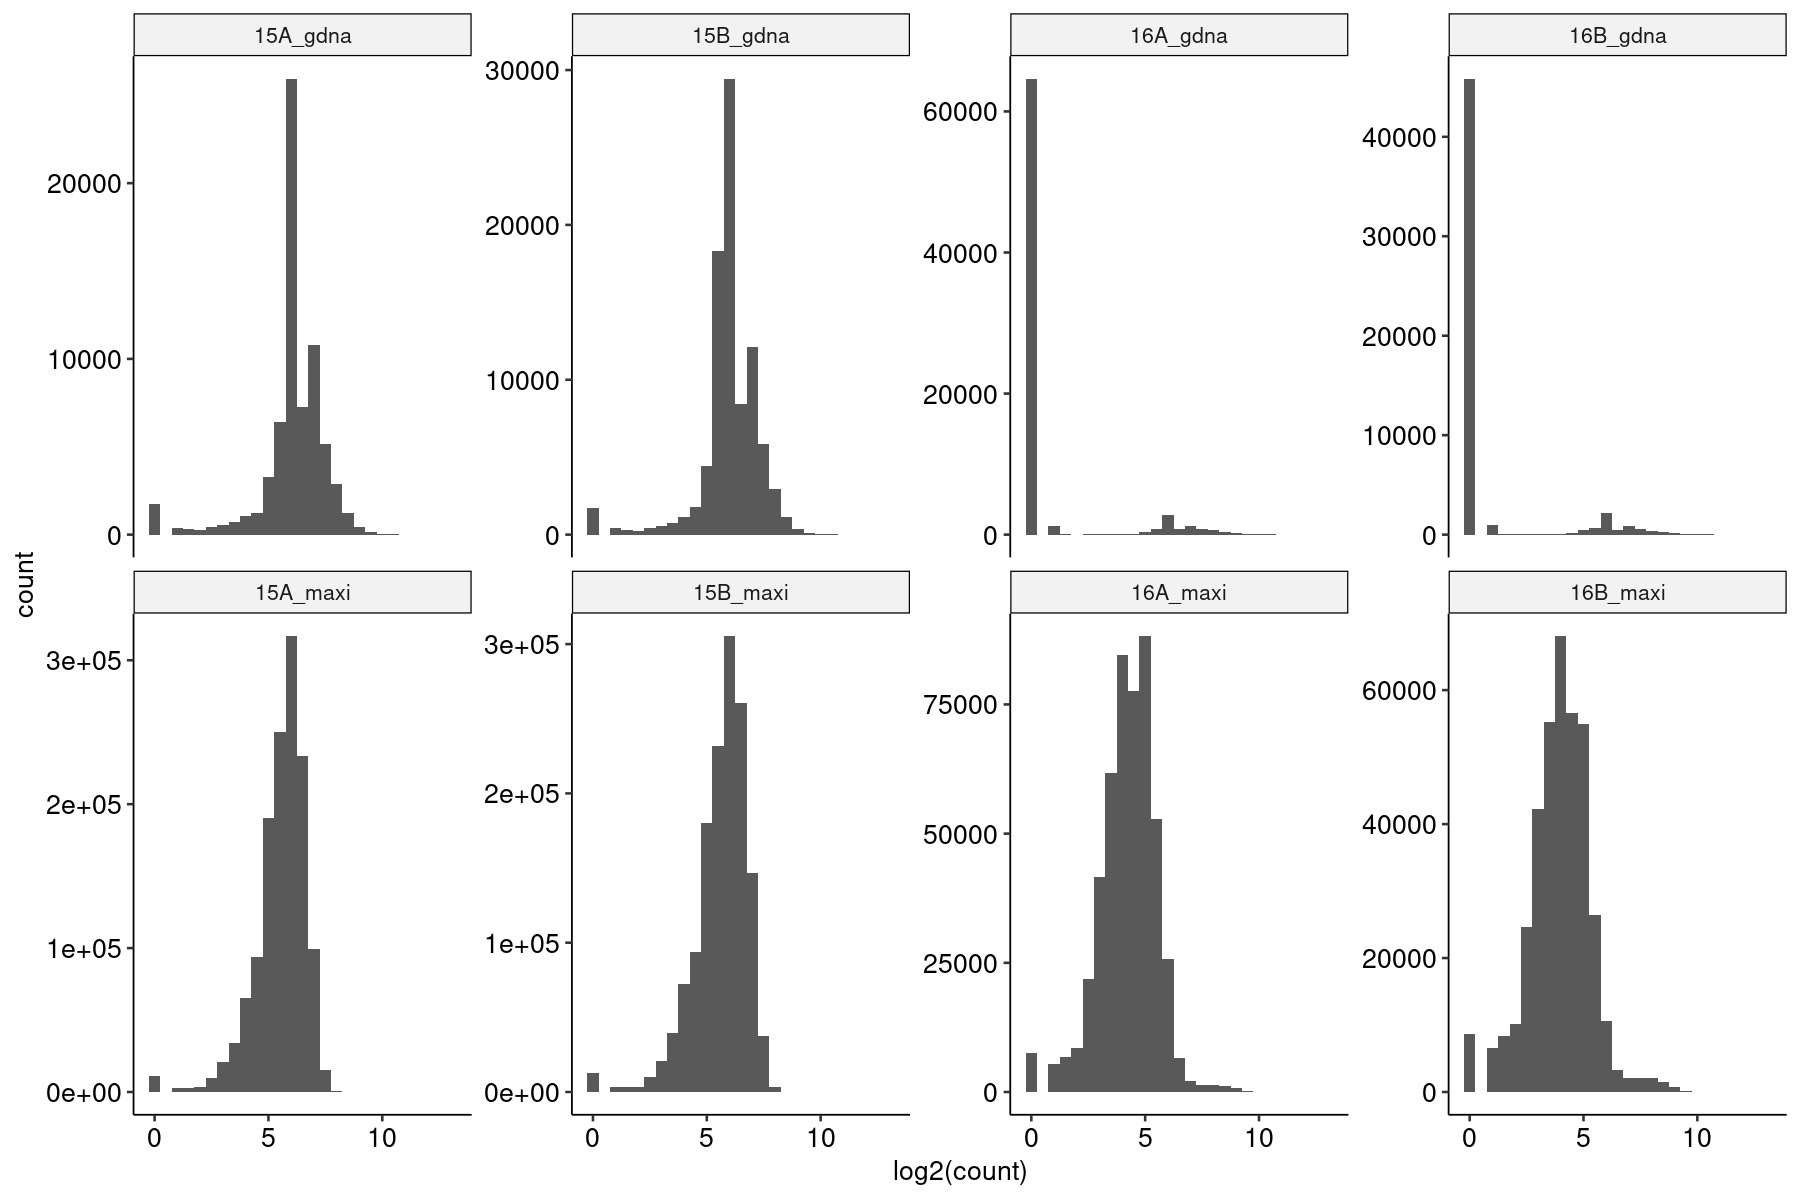

In [44]:
options(repr.plot.width = 15, repr.plot.height = 10)
mapped_counts %>%
    mutate(sample = factor(sample, levels = c("15A_gdna", "15B_gdna",
                                              "16A_gdna", "16B_gdna",
                                              "15A_maxi", "15B_maxi",
                                              "16A_maxi", "16B_maxi"))) %>%
    ggplot() +
        geom_histogram(aes(x = log2(count)), binwidth = 0.5) +
        facet_wrap(~sample, scales = "free_y", nrow = 2) +
        theme_pubr(base_size = 16)

If we check the total number of unique barcodes in each sample, we find similar numbers in both chunk 15 and chunk 16 gDNA. The difference (based on the above plot) is that most of these barcodes are very low abundance in chunk 16, while they have the expected distribution in chunk 15:

In [55]:
mapped_counts %>%
    count(sample) %>%
    rename("number of mapped barcodes detected" = "n") %>%
    kable("markdown")

mapped_counts %>%
    group_by(sample) %>%
    summarize(n = median(count)) %>%
    rename("median read count per mapped barcode" = "n") %>%
    kable("markdown")



|sample   | number of mapped barcodes detected|
|:--------|----------------------------------:|
|15A_gdna |                              70342|
|15A_maxi |                            1350060|
|15B_gdna |                              90503|
|15B_maxi |                            1424653|
|16A_gdna |                              74227|
|16A_maxi |                             496077|
|16B_gdna |                              53241|
|16B_maxi |                             384350|



|sample   | median read count per mapped barcode|
|:--------|------------------------------------:|
|15A_gdna |                                   69|
|15A_maxi |                                   53|
|15B_gdna |                                   61|
|15B_maxi |                                   56|
|16A_gdna |                                    1|
|16A_maxi |                                   20|
|16B_gdna |                                    1|
|16B_maxi |                                   16|